# Algorithm Chains and Pipelines

In [1]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# load and split the data
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

# compute minimum and maximum on the training data
scaler = MinMaxScaler().fit(X_train)

In [2]:
X_train.shape

(426, 30)

In [3]:
X_train[:2]

array([[  1.18500000e+01,   1.74600000e+01,   7.55400000e+01,
          4.32700000e+02,   8.37200000e-02,   5.64200000e-02,
          2.68800000e-02,   2.28000000e-02,   1.87500000e-01,
          5.71500000e-02,   2.07000000e-01,   1.23800000e+00,
          1.23400000e+00,   1.38800000e+01,   7.59500000e-03,
          1.50000000e-02,   1.41200000e-02,   8.57800000e-03,
          1.79200000e-02,   1.78400000e-03,   1.30600000e+01,
          2.57500000e+01,   8.43500000e+01,   5.17800000e+02,
          1.36900000e-01,   1.75800000e-01,   1.31600000e-01,
          9.14000000e-02,   3.10100000e-01,   7.00700000e-02],
       [  1.12200000e+01,   1.98600000e+01,   7.19400000e+01,
          3.87300000e+02,   1.05400000e-01,   6.77900000e-02,
          5.00600000e-03,   7.58300000e-03,   1.94000000e-01,
          6.02800000e-02,   2.97600000e-01,   1.96600000e+00,
          1.95900000e+00,   1.96200000e+01,   1.28900000e-02,
          1.10400000e-02,   3.29700000e-03,   4.96700000e-03,
       

In [4]:
# rescale the training data
X_train_scaled = scaler.transform(X_train)

svm = SVC()
# learn an SVM on the scaled training data
svm.fit(X_train_scaled, y_train)

# scale the test data and score the scaled data
X_test_scaled = scaler.transform(X_test)

print("Test score: {:.2f}".format(svm.score(X_test_scaled, y_test)))

Test score: 0.95


## Parameter Selection with Preprocessing

In [5]:
from sklearn.model_selection import GridSearchCV
# for illustration purposes only, don't use this code!
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)

print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Test set accuracy: {:.2f}".format(grid.score(X_test_scaled, y_test)))

Best cross-validation accuracy: 0.98
Best parameters:  {'gamma': 1, 'C': 1}
Test set accuracy: 0.97


Here, we ran the grid search over the parameters of SVC using the scaled data

In [6]:
import introduction_to_ml_with_python.mglearn as mglearn

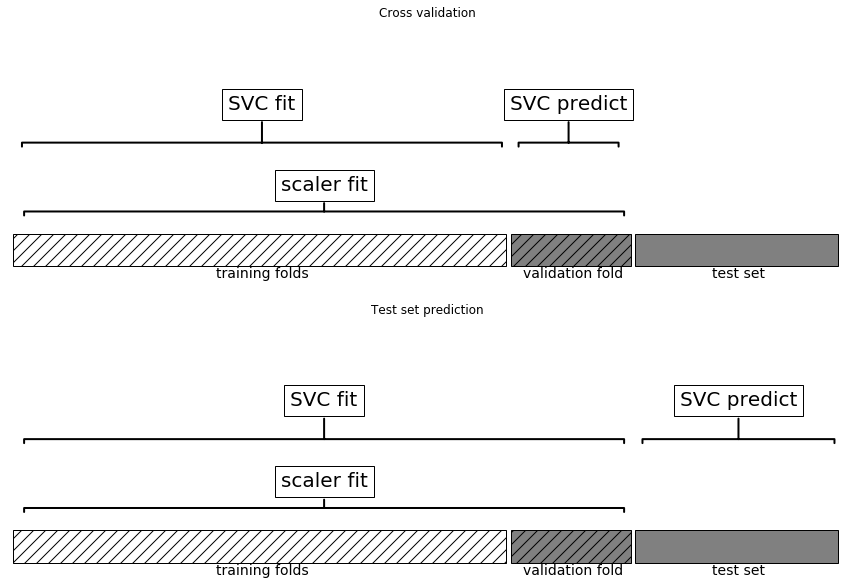

In [7]:
mglearn.plots.plot_improper_processing()

The Pipeline class itself has fit, predict, and score methods and behaves just like any other model in scikit-learn. 

## Building Pipelines

In [8]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ("scaler", MinMaxScaler()),  # any string of your choosing
    ("svm", SVC())
])

In [9]:
# For the last step in the pipeline, just fit is called.
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

Here, pipe.fit first calls fit on the first step (the scaler), then transforms the training data using the scaler, and finally fits the SVM with the scaled data.

In [10]:
print("Test score: {:.2f}".format(pipe.score(X_test, y_test)))

Test score: 0.95


Calling the score method on the pipeline first transforms the test data using the scaler, and then calls the score method on the SVM using the scaled test data.

The main benefit of using the pipeline, however, is that we can now use this single estimator in `cross_val_score` or `GridSearchCV`.

## Using Pipelines in Grid Searches

In [11]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [12]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.98
Test set score: 0.97
Best parameters: {'svm__C': 1, 'svm__gamma': 1}


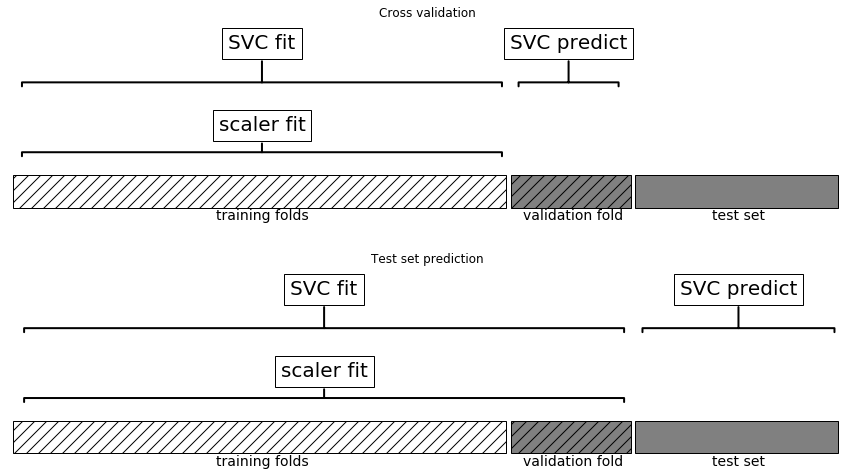

In [13]:
mglearn.plots.plot_proper_processing()

the MinMaxScaler is refit with only the training splits and no information is leaked from the test split into the parameter search.

### ILLUSTRATING INFORMATION LEAKAGE

In [14]:
import numpy as np

In [15]:
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

In [16]:
from sklearn.feature_selection import SelectPercentile, f_regression

select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)
print("X_selected.shape: {}".format(X_selected.shape))

X_selected.shape: (100, 500)


In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge

print("Cross-validation accuracy (cv only on ridge): {:.2f}".format(np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))))

Cross-validation accuracy (cv only on ridge): 0.91


The mean $R^2$ computed by cross-validation is 0.91, indicating a very good model. This clearly cannot be right, as our data is entirely random.

Because we fit the feature selection outside of the cross-validation, it could find features that are correlated both on the training and the test folds. (by chance) 

 Let’s compare this to a proper cross-validation using a pipeline:

In [18]:
pipe = Pipeline([
    ("select", SelectPercentile(score_func=f_regression,percentile=5)),
    ("ridge", Ridge())])

print("Cross-validation accuracy (pipeline): {:.2f}".format(np.mean(cross_val_score(pipe, X, y, cv=5))))

Cross-validation accuracy (pipeline): -0.25


This time, we get a negative $R^2$ score, indicating a very poor model. 

Using the pipeline, the feature selection is now inside the cross-validation loop. This means features can only be selected using the `training folds` of the data, not the `test fold`.

## The General Pipeline Interface

The only requirement for estimators in a pipeline is that all but the last step need to have a transform method, so they can produce a new representation of the data that can be used in the next step.

During the call to Pipeline.fit, the pipeline calls fit and then transform on each step in turn.

Overview of the pipeline training and prediction process
![](fit-transform-pipe.png)

### Convenient Pipeline Creation with make_pipeline

In [19]:
from sklearn.pipeline import make_pipeline

# standard syntax
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])

# abbreviated syntax
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

In [20]:
print("Pipeline steps:\n{}".format(pipe_short.steps))

Pipeline steps:
[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]


In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print("Pipeline steps:\n{}".format(pipe.steps))

Pipeline steps:
[('standardscaler-1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler-2', StandardScaler(copy=True, with_mean=True, with_std=True))]


### Accessing Step Attributes

In [22]:
# fit the pipeline defined before to the cancer dataset
pipe.fit(cancer.data)

# extract the first two principal components from the "pca" step
components = pipe.named_steps["pca"].components_
print("components.shape: {}".format(components.shape))

components.shape: (2, 30)


### Accessing Attributes in a Pipeline inside GridSearchCV


In [23]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression())

In [24]:
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

In [25]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=4)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [29]:
X_train.shape

(426, 30)

In [26]:
print("Best estimator:\n{}".format(grid.best_estimator_))

Best estimator:
Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])


In [27]:
print("Logistic regression step:\n{}".format(grid.best_estimator_.named_steps["logisticregression"]))

Logistic regression step:
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [28]:
print("Logistic regression coefficients:\n{}".format(grid.best_estimator_.named_steps["logisticregression"].coef_))

Logistic regression coefficients:
[[-0.38856355 -0.37529972 -0.37624793 -0.39649439 -0.11519359  0.01709608
  -0.3550729  -0.38995414 -0.05780518  0.20879795 -0.49487753 -0.0036321
  -0.37122718 -0.38337777 -0.04488715  0.19752816  0.00424822 -0.04857196
   0.21023226  0.22444999 -0.54669761 -0.52542026 -0.49881157 -0.51451071
  -0.39256847 -0.12293451 -0.38827425 -0.4169485  -0.32533663 -0.13926972]]


## Grid-Searching Preprocessing Steps and Model Parameters

In [30]:
from sklearn.datasets import load_boston

boston = load_boston()

X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,random_state=0)

from sklearn.preprocessing import PolynomialFeatures

pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge())

Using our pipeline, we can search over the degree parameter together with the parameter alpha of Ridge.

In [31]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

In [32]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100], 'polynomialfeatures__degree': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [34]:
import matplotlib.pyplot as plt

In [40]:
param_grid['ridge__alpha']

[0.001, 0.01, 0.1, 1, 10, 100]

In [39]:
range(len(param_grid['ridge__alpha']))

range(0, 6)

In [44]:
grid.cv_results_['mean_test_score']

array([ 0.72169353,  0.721697  ,  0.72173126,  0.7220378 ,  0.72307143,
        0.70772151])

In [42]:
grid.cv_results_['mean_test_score'].shape

(6,)

In [48]:
grid.cv_results_['mean_test_score'].reshape(1, -1).shape

(1, 6)

In [43]:
grid.cv_results_['mean_test_score'].reshape(3, -1).shape

(3, 2)

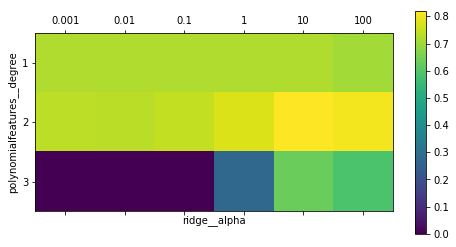

In [35]:
plt.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1),vmin=0, cmap="viridis")

plt.xlabel("ridge__alpha")
plt.ylabel("polynomialfeatures__degree")
plt.xticks(range(len(param_grid['ridge__alpha'])), param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])), param_grid['polynomialfeatures__degree'])

plt.colorbar()

In [36]:
print("Best parameters: {}".format(grid.best_params_))

Best parameters: {'ridge__alpha': 10, 'polynomialfeatures__degree': 2}


In [37]:
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Test-set score: 0.77


In [38]:
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("Score without poly features: {:.2f}".format(grid.score(X_test, y_test)))

Score without poly features: 0.63


As we would expect looking at the grid search results visualized previously, using no polynomial features leads to decidedly worse results.

keep in mind that GridSearchCV tries all possible combinations of the specified parameters. Therefore, adding more parameters to your grid exponentially increases the number of models that need to be built.

## Grid-Searching Which Model To Use

For the SVC might need the data to be scaled, so we also search over whether to use StandardScaler or no preprocessing. 

For the RandomForestClassifier, we know that no preprocessing is necessary

In [49]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

Because they have different parameters to tune, and need different preprocessing, we can make use of the list of search grids we discussed in “Search over spaces that are not grids”. 

In [52]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {'classifier': [SVC()], # either svc or
     'preprocessing': [StandardScaler(), None],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
    },
    {'classifier': [RandomForestClassifier(n_estimators=100)], # rfc
     'preprocessing': [None],  
     # When we wanted to skip a step in the pipeline (for example, because we don’t need preprocessing for the RandomForest), we can set that step to None
     'classifier__max_features': [1, 2, 3]
    }]

In [53]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best params:
{'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'classifier__C': 10, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True), 'classifier__gamma': 0.01}

Best cross-validation score: 0.99
Test-set score: 0.98


The outcome of the grid search is that SVC with StandardScaler preprocessing, C=10, and gamma=0.01 gave the best result.